In [49]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_call_price

from data import DataFromFolder, DataRes
from utils import call_payoff, stochastic_integral
from models import ControlNet, EnsembleNet
from train import train_val
from evaluation import get_eval_data
from risk_measures import median_loss

import yfinance as yf
from arch import arch_model
import dask.dataframe as dd

from tqdm import tqdm, trange

from typing import Callable, Optional
import multiprocessing
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

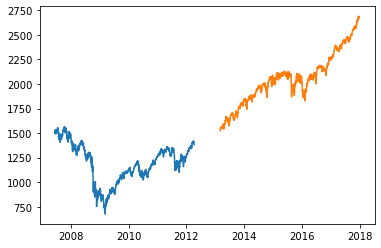

In [2]:
ticker = yf.Ticker('^GSPC')
hist_v1 = ticker.history(start='2013-03-04', end='2018-01-02').Close
hist_v2 = ticker.history(start='2007-06-11', end='2012-04-10').Close
plt.plot(hist_v2);
plt.plot(hist_v1)

In [3]:
# From fitting the GARCH model using R get following parameters

SIGMA_V1 = 0.0643661
SIGMA_V2 = 0.1221684

MU_V1 = 0.048758
MU_V2 = 0.056105

SQRT_252 = 252 ** 0.5

In [4]:
h_params = {"N_SIM": 4000,
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.005,
            "GAMMA": 0.96,
            "EPOCHS": 10,
            "BATCH_SIZE": 256,}

In [5]:
initial_value = hist_v2.iloc[0]
strike = initial_value
n_steps = 30
price = bs_call_price(n_steps, initial_value, SIGMA_V2, h_params["RF"], strike)
initial_value, strike, SIGMA_V2, price

(1509.1199951171875, 1509.1199951171875, 0.1221684, 21.0855397479188)

In [6]:
dt = DataFromFolder("v2/", price, call_payoff, {"strike": strike}, splits=h_params["N_SIM"], S0=initial_value, sigma_0=SIGMA_V2, mu_const=MU_V2, take_log=True)


## Training

In [7]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 1000
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 2, [20, 20], 1, learn_price=False, learn_vol=True)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|█████| 334/334 [00:25<00:00, 13.15batch/s, loss=63.2, metric=19.2]


validation loss: 937.8272857666016


Epoch 5: 100%|█████| 334/334 [00:23<00:00, 13.98batch/s, loss=46.4, metric=17.1]


validation loss: 2639.3898803710936


Epoch 0: 100%|█████| 333/333 [00:25<00:00, 12.87batch/s, loss=61.2, metric=13.4]


validation loss: 2360.908740234375


Epoch 5: 100%|█████| 333/333 [00:24<00:00, 13.38batch/s, loss=44.6, metric=10.3]


validation loss: 4130.154479980469


Epoch 0: 100%|█████| 333/333 [00:24<00:00, 13.34batch/s, loss=49.1, metric=16.1]


validation loss: 51.69661331176758


Epoch 5: 100%|███████| 333/333 [00:24<00:00, 13.45batch/s, loss=34, metric=14.8]


validation loss: 40.53351020812988


Epoch 9: 100%|█████| 333/333 [00:24<00:00, 13.54batch/s, loss=34.4, metric=14.7]

CPU times: user 14min 31s, sys: 3min 30s, total: 18min 2s
Wall time: 12min 23s


## Performance on GJR validation paths & Delta Hedging Benchmark

In [8]:
# Cython code based on: https://github.com/JackJacquier/python-for-finance/blob/master/Session-7-Cython/Intro_to_Cython.ipynb

In [9]:
%load_ext Cython

In [10]:
%%cython --compile-args=-O3
cimport cython
from libc.math cimport  sqrt,log,exp,erf
cdef double ONE_OVER_SQRT_TWO=0.7071067811865476
import numpy as np
cimport numpy as cnp

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef double gaussian_cdf(double x) nogil:
    return 0.5*(1+erf(x*ONE_OVER_SQRT_TWO))

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef cnp.ndarray[cnp.double_t, ndim=1] cython_bs_delta(cnp.ndarray[cnp.double_t, ndim=1] sigma, cnp.ndarray[cnp.double_t, ndim=1] S0,double K, cnp.ndarray[cnp.double_t, ndim=1] T):
    cdef int size=len(S0)
    cdef double k, d1, sigmaT
    cdef cnp.ndarray[cnp.double_t, ndim=1] result=np.zeros(size)
        
    with nogil:
        for i in range(size):
            sigmaT = sigma[i] * sqrt(T[i])
            k = log(S0[i] / K)
            d1 = k / sigmaT + 0.5*sigmaT
            result[i] = gaussian_cdf(d1)
        
    return result

In [11]:
# make index to pass decreasing time to maturity to the bs_delta function
idx = np.arange(n_steps) + 1
idx = idx[::-1]

In [12]:
def cython_d_hedge(x, vol):
    return cython_bs_delta(vol.numpy().astype(np.float64), torch.exp(x).numpy().astype(np.float64), strike, idx.astype(np.float64) *  ( 1 / 365))

In [13]:
def hedge_diff(x, x1, x_inc, payoff, price, vol, model=ens, normalized=True):

    # calculate delta hedge; assuming x is log price!
    if normalized:
        path = initial_value * x
    else:
        path = x
    
    d_hedge_list = [cython_d_hedge(a.squeeze(), b.squeeze()) for a, b in zip(path, vol)]
    si_delta = stochastic_integral(x_inc, torch.Tensor(d_hedge_list))
    diff_delta = (price.squeeze() + si_delta).float() - payoff.float()

    # calculating model hedge
    if model.learn_price:
        output, price = model(x, x1)
    else:
        output = model(x, x1)

    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()

    return diff, diff_delta

In [14]:
diffs, diffs_delta = [], []

for i in np.arange(start=3500, stop=3700):
    
    x, x1, x_inc, payoff, price = dt[i]
    vol = dt.get_vol(i)
    
    diff, diff_delta = hedge_diff(x, x1, x_inc, payoff, price, vol)
    diffs.append(diff)
    diffs_delta.append(diff_delta)
    
d = torch.cat(diffs)
d_delta = torch.cat(diffs_delta)

In [15]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

print('Delta Hedge:')
print(f"RMSE {(d_delta ** 2).mean() ** 0.5}")
print(f"Using median {(d_delta ** 2).median() ** 0.5}")
print(f"Using mode {(d_delta ** 2).mode()[0] ** 0.5}")

Model:
RMSE 6.6079888343811035
Using median 3.296205520629883
Using mode 0.45098114013671875
Delta Hedge:
RMSE 15.667876243591309
Using median 9.739227294921875
Using mode 21.085538864135742


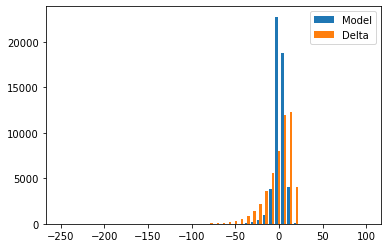

In [16]:
plt.hist([d.detach().numpy(), d_delta.detach().numpy()], range=(-250, 100), bins=50, label=['Model', 'Delta'])
plt.legend();

In [17]:
pd.Series(d_delta.detach()).describe()

count    51200.000000
mean        -0.094304
std         15.667855
min       -204.078278
25%         -7.247254
50%          3.881438
75%         10.595092
max         21.085539
dtype: float64

In [18]:
d_series = pd.Series(d.detach())
d_series.describe()

count    51200.000000
mean         1.129272
std          6.510819
min       -137.689209
25%         -1.442556
50%          1.410717
75%          4.748440
max         21.456221
dtype: float64

## Performance on real paths

In [19]:
# Creating the validation paths
n_steps = 30
step = 5  # number of days by which to shift the window 
valid_paths, valid_prices, valid_strikes = [], [], []

for i in np.arange(start=0, stop=len(hist_v2) - n_steps, step=step):
    
    valid_path = hist_v2[i:i+n_steps+1]
    S0 = valid_path[0]
    valid_price = bs_call_price(n_steps, S0, sigma=SIGMA_V2, rf=0, strike=S0)  # TODO: CORRECT SIGMA HERE    
    
    valid_paths.append(valid_path)
    valid_strikes.append(S0)
    valid_prices.append(valid_price)

valid_paths = np.array(valid_paths)
valid_paths = valid_paths.reshape(valid_paths.shape[0], valid_paths.shape[1], 1)
valid_paths = torch.from_numpy(valid_paths).float()

valid_prices = torch.Tensor(valid_prices)
valid_strikes = torch.Tensor(valid_strikes)

In [23]:
if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()

    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)

In [24]:
paths.shape

torch.Size([238, 30, 1])

In [25]:
x1 = torch.ones(paths.shape) * SIGMA_V2 #!!!!!!FIX THIS WITH THE SIGMA
output = ens(paths, x1)
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

In [26]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")

Model:
RMSE 29.3735408782959
Using median 15.418793678283691


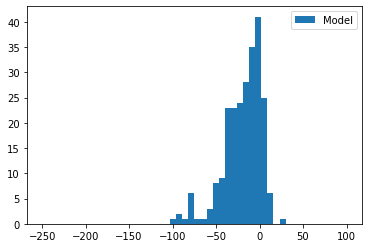

In [27]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

In [28]:
d_series = pd.Series(d.detach())
d_series.describe()

count    238.000000
mean     -19.207212
std       22.270416
min     -102.659485
25%      -31.327005
50%      -14.934292
75%       -2.380696
max       23.117968
dtype: float64

In [29]:
# TODO:
# Sigma not correct yet that is used to caldulate the BS price
# Would also need that to implement delte hedging

## Reservoir paths

In [30]:
res_dt = DataRes('resssim/', price, call_payoff, {"strike": strike}, splits=100, S0=initial_value, take_log=True)

In [31]:
diffs = []

for i in range(100):
    x, x1, x_inc, payoff, price = res_dt[i]
    output = ens(x, x1) #SECOND ARGUMENT VOL RN IT"S PATH
    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()
    diffs.append(diff)
    
d = torch.cat(diffs)

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 14.76026725769043
Using median 10.164070129394531
Using mode 0.4495849609375


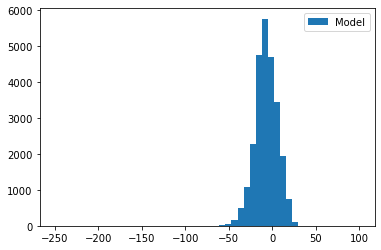

In [32]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

## Compare with training on reservoir paths

In [33]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 900
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 1, [20, 20], 1, learn_price=False, learn_vol=False)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(res_dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|███████| 300/300 [00:12<00:00, 23.70batch/s, loss=93, metric=45.6]


validation loss: 6233.294506835938


Epoch 5: 100%|█████| 300/300 [00:12<00:00, 24.28batch/s, loss=85.5, metric=52.4]


validation loss: 22482.0603515625


Epoch 0: 100%|█████| 300/300 [00:12<00:00, 23.85batch/s, loss=93.7, metric=53.1]


validation loss: 20251.6462890625


Epoch 5: 100%|█████| 300/300 [00:12<00:00, 24.37batch/s, loss=83.9, metric=48.5]


validation loss: 4458.723120117187


Epoch 0: 100%|█████| 300/300 [00:12<00:00, 23.97batch/s, loss=92.2, metric=54.4]


validation loss: 7670.538427734375


Epoch 5: 100%|█████| 300/300 [00:12<00:00, 24.23batch/s, loss=77.6, metric=45.4]


validation loss: 5248.592553710938


Epoch 9: 100%|█████| 300/300 [00:12<00:00, 24.46batch/s, loss=74.8, metric=47.1]

CPU times: user 6min 51s, sys: 41 s, total: 7min 32s
Wall time: 6min 12s


In [34]:
# Out of sample performance

diffs = []

for i in np.arange(n+10,1000):
    x, x1, x_inc, payoff, price = res_dt[i]
    output = ens(x, x1)
    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()
    diffs.append(diff)
    
d = torch.cat(diffs)

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 8.999910354614258
Using median 7.230079650878906
Using mode 0.3242301940917969


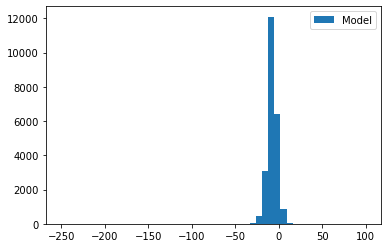

In [35]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

In [36]:
output.shape

torch.Size([256, 30])

In [37]:
# Performance on real data

if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()
    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)
    
    
output = ens(paths, paths) #VOLLLLL
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 26.824016571044922
Using median 16.147979736328125
Using mode 0.03843498229980469


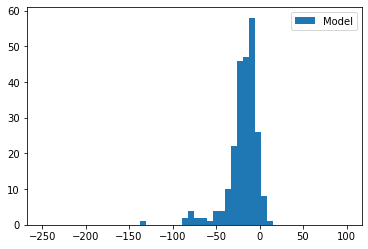

In [38]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

### Plotting training, validation loss & metric

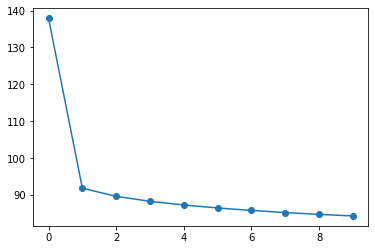

In [39]:
l, vl, m = res_list[1]
plt.plot(l, marker='o')

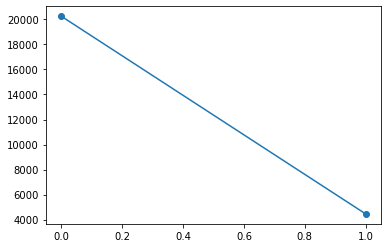

In [40]:
plt.plot(vl, marker='o')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


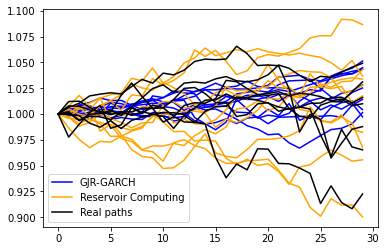

In [51]:
gjr_x, _, _, _, _ = dt[1]
res_x, _, _, _, _ = res_dt[1]
gjr_x, res_x = torch.exp(gjr_x), torch.exp(res_x)

gjr_example_paths = gjr_x[:10]
res_example_paths= res_x[:10]

fut = ticker.history(start='2018-01-02', end='2019-01-02').Close
m = np.floor(len(fut) / n_steps)
real_example_paths = []

for i in np.arange(start=0, stop=(m-1)*n_steps, step=n_steps):
    i = int(i)
    path = fut.iloc[i:i+n_steps].values
    path = path / path[0]
    real_example_paths.append(path)

plt.plot(gjr_example_paths.T.squeeze(), c='blue');
plt.plot(res_example_paths.T.squeeze(), c='orange');
plt.plot(np.array(real_example_paths).T, c='black');

# plt.legend(['GJR-GARCH', 'Reservoir Computing', 'Real paths'])
gjrpath_leg = Line2D([0], [0], color='blue', label='GJR-GARCH')
rc_leg = Line2D([0], [0], color='orange', label='Reservoir Computing')
real_leg = Line2D([0], [0], color='black', label='Real paths')
plt.legend(handles=[gjrpath_leg, rc_leg, real_leg])

plt.savefig('compare_paths.eps', format='eps')

plt.show()